In [1]:
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import pandas as pd
from sklearn import linear_model

import requests
from bs4 import BeautifulSoup
import pandas as pd
import random
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import pickle
import scrapy
import json

with open('autotrader_make_models3.pickle', 'rb') as handle:
    make_models = pickle.load(handle)

all_makes = list(make_models.keys())
chromrdriver = r"C:\Users\alfab\Documents\chromedriver.exe"
os.environ["webdriver.chrome.driver"] = chromrdriver

In [3]:
#create file structure
src_folder = 'scraped_page_src'
#page_src --> make --> model ---> make_model_0.html, make_model_1.html, make_model_2.html,,,,,
for make in list(make_models.keys()):
     os.makedirs(os.path.join(src_folder,make))

for make in list(make_models.keys()):
    make_path = os.path.join(src_folder,make)
    for model in make_models[make]:
         os.makedirs(os.path.join(make_path,model.replace('/','_')))

In [37]:
target_url = get_url(make_models['toyota'][2],0)
chromrdriver = r"C:\Users\alfab\Documents\chromedriver.exe"
os.environ["webdriver.chrome.driver"] = chromrdriver
driver = webdriver.Chrome(chromrdriver)
driver.get(target_url)

In [2]:
# def get_url(makemodel,page_num):
#     base='https://www.autotrader.com/cars-for-sale/all-cars/'
#     PageNumberString = str(page_num*100)
#     remainder = 'washington-dc-20500?dma=&maxMileage=200000&searchRadius=0&location=&marketExtension=include&isNewSearch=false&showAccelerateBanner=false&sortBy=relevance&numRecords=100&firstRecord='+PageNumberString
#     return(base+makemodel+remainder)
location='washington-dc-20500'
def get_url(makemodel,location,startyear,endyear):
    base_url = 'https://www.autotrader.com/cars-for-sale/all-cars/'
    location_text = location+'?dma=&maxMileage=200000&searchRadius=0&location=&marketExtension=include&'
    date_range = 'endYear='+str(endyear)+'&startYear='+str(startyear)
    page_info ='&isNewSearch=true&showAccelerateBanner=false&sortBy=relevance&numRecords=100'
    return(base_url+makemodel+location_text+date_range+page_info)

def single_scrape(makemodel,make,location,startyear,endyear):
    target_folder = os.path.join('scraped_page_src',make)
    model_folder = os.path.join(target_folder,makemodel.replace('/','_'))
    
    target_url = get_url(makemodel,location,startyear,endyear)
    chromrdriver = r"C:\Users\alfab\Documents\chromedriver.exe"
    os.environ["webdriver.chrome.driver"] = chromrdriver
    driver = webdriver.Chrome(chromrdriver)
    driver.get(target_url)
    
    file = open(os.path.join(model_folder,makemodel.replace('/','_')+str(startyear)+'-'+str(endyear)+'.html'),'w',encoding = 'utf-8')
    file.write(driver.page_source)
    file.close()
#     time.sleep(6)
    driver.close()


In [8]:
def extract_data(target_page):
    data = open(target_page,'r',encoding='utf-8')
    soup = BeautifulSoup(data, 'html.parser')
    all_listings = soup.find_all("div",{"data-cmp":"inventoryListing"})
    
    make_model = [target_page.split('\\')[2]]*len(all_listings)
    year = []
    price = []
    milage_infos = []

    for i in range(len(all_listings)):
        try:
            vehicle_price = all_listings[i].find_all("span", {"class":"first-price"})[0].text
            vehicle_price = float(vehicle_price.replace(",",""))
        except:
            vehicle_price ='na'
        try:
            vehicle_milage = all_listings[i].find_all("div", {"class":"item-card-specifications col-xs-9 margin-top-4 text-subdued-lighter margin-bottom-3"})[0].text
            vehicle_milage = float(vehicle_milage.split("miles")[0][:-1].replace(",",""))
        except:
            vehicle_milage = 'na'
        try:
            vehicle_year = all_listings[i].find_all("div", {"class":"display-flex justify-content-between"})[0].text
            vehicle_year = float(vehicle_year.split(" ")[1])-2000
        except:
            vehicle_year='na'


        year.append(vehicle_year)
        price.append(vehicle_price)
        milage_infos.append(vehicle_milage)
        
    return({"make_model":make_model,"year":year,"milage":milage_infos,"price":price})

def remove_na(df):
    rows_to_drop=[]
    for row in range(len(df)):
        for col in list(df.columns):
            if df.iloc[row][col] =='na':
                rows_to_drop.append(row)
    output_df = df.drop(rows_to_drop)
    return(output_df)

In [424]:
data = open(target_page,'r',encoding='utf-8')
soup = BeautifulSoup(data, 'html.parser')
all_listings = soup.find_all("div",{"data-cmp":"inventoryListing"})
name_info = all_listings[0].find_all("div", {"class":"item-card-specifications col-xs-9 margin-top-4 text-subdued-lighter margin-bottom-3"})[0].text

In [ ]:
all_makes = list(make_models.keys())

# all_makes[0:7]
# all_makes[7:14]
# all_makes[14:21]
# all_makes[21:28]
# all_makes[28:]

location = 'washington-dc-20500'

startyears = [2000,2006,2011,2016]
endyears = [2005,2010,2015,2021]

for make in all_makes[0:1]:
    for model in make_models[make]:
        for i in range(len(startyears)):
            single_scrape(model,make,location,startyears[i],endyears[i])

In [402]:
input_df = df[['year', 'milage', 'price']].reset_index(drop=True)
input_df = remove_na(input_df)
reg = linear_model.LinearRegression()
reg.fit(input_df[['year','milage']],input_df['price'])
price_model[model] = [reg.coef_[0], reg.coef_[1],reg.intercept_]

In [326]:
make = 'Acura'
startyear1 = 2005
endyear1 = 2014
location = 'washington-dc-20500'
startyear2 = 2015
endyear2 = 2021

makemodel = make_models[make][1]
target_folder = os.path.join('scraped_page_src',make)
model_folder = os.path.join(target_folder,makemodel.replace('/','_'))
target_page = os.path.join(model_folder,makemodel.replace('/','_')+str(startyear1)+'-'+str(endyear1)+'.html')


acura_ilx_dict = extract_data(target_page)

df = pd.DataFrame(acura_ilx_dict)
df = remove_na(df)

In [327]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.figure import Figure
y = df['price']
x1 = df['milage']
x2 = df['year']

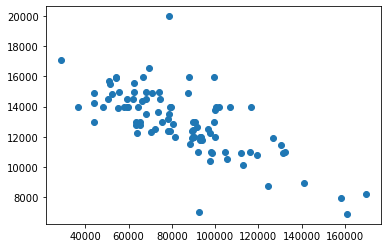

In [328]:
plt.scatter(x1,y)

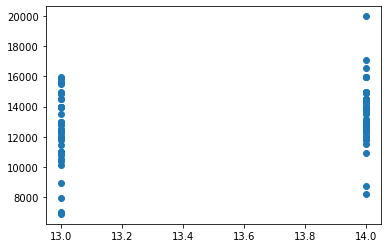

In [329]:
plt.scatter(x2,y)

In [332]:
input_df

,year,milage,price
0,13.0,62569.0,15590
1,14.0,67950.0,14990
2,14.0,72435.0,12500
3,14.0,65484.0,13000
4,14.0,55321.0,13931
...,...,...,...
94,13.0,105720.0,10495
95,13.0,98226.0,10998
97,13.0,97585.0,10409
98,14.0,100456.0,13999


In [331]:
input_df = df[['year', 'milage', 'price']]
reg = linear_model.LinearRegression()
reg.fit(input_df[['year','milage']],input_df['price'])

LinearRegression()

In [333]:
reg.coef_

array([ 7.36097418e+02, -5.45240512e-02])

In [334]:
reg.intercept_

7675.536466415794

In [343]:
price_model(20,0,reg)

22397.48483479426

In [412]:
def price_suggestion(price_model, makemodel, year, milage):
    coefficients = price_model[makemodel]
    return((year-2000)*coefficients[0] + milage*coefficients[1]+coefficients[2])

In [418]:
price_suggestion(price_model, 'toyota/corolla/', 2010, 200000)

5415.649959754452

In [437]:
len(vehicle_data_frames)

315

In [438]:
vehicle_keys = list(vehicle_data_frames.keys())

In [440]:
vehicle_keys[314]

'gmc/typhoon/'

In [11]:
price_model={}
vehicle_data_frames={}

# all_makes[0:7]
# all_makes[7:14]
# all_makes[14:21]
# all_makes[21:28]
# all_makes[28:]

location = 'washington-dc-20500'

startyears = [2000,2006,2011,2016]
endyears = [2005,2010,2015,2021]

for make in all_makes:
    for model in make_models[make]:
        df = pd.DataFrame(columns = ['make_model', 'year', 'milage', 'price'])
        for i in range(len(startyears)):
#             single_scrape(model,make,location,startyears[i],endyears[i])
            
            makemodel = model
            target_folder = os.path.join('scraped_page_src',make)
            model_folder = os.path.join(target_folder,makemodel.replace('/','_'))            
            target_page = os.path.join(model_folder,makemodel.replace('/','_')+str(startyears[i])+'-'+str(endyears[i])+'.html')
            
            make_model_dict = extract_data(target_page)
            try:
                df = df.append(pd.DataFrame(make_model_dict))
                df = remove_na(df)
            except:
                pass
        vehicle_data_frames[model]=df
            
#         input_df = df[['year', 'milage', 'price']].reset_index(drop=True)
#         input_df = remove_na(input_df)
#         reg = linear_model.LinearRegression()
#         reg.fit(input_df[['year','milage']],input_df['price'])
#         price_model[model] = [reg.coef_[0], reg.coef_[1],reg.intercept_]


In [9]:
with open('vehicle_dataframes1.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [19]:
price_model={}
for makemodel in list(vehicle_data_frames.keys()):
    df = vehicle_data_frames[makemodel]
    input_df = df[['year', 'milage', 'price']].reset_index(drop=True)
    input_df = remove_na(input_df)
    reg = linear_model.LinearRegression()
    try:
        reg.fit(input_df[['year','milage']],input_df['price'])
        price_model[makemodel] = [reg.coef_[0], reg.coef_[1],reg.intercept_,len(input_df)]
    except:
        price_model[makemodel] = 'na'


In [17]:
# # Store data (serialize)
# with open('vehicle_dataframes_dict_final.pickle', 'wb') as handle:
#     pickle.dump(vehicle_data_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('vehicle_dataframes_dict_final.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [26]:
make_models['Acura'][0]

'acura/cl/'

In [31]:
acura_cl = price_model[make_models['Acura'][0]]

In [32]:
2005*acura_cl[0]+acura_cl[1]

[1332.9640426557621, -0.048131228802439835, 9229.899384938388, 8]

In [34]:
input_df

,year,milage,price
0,4.0,161851,4495
1,4.0,69200,8850
2,4.0,119535,6795
3,5.0,167437,3500
4,5.0,128000,5995
...,...,...,...
336,20.0,7830,50999
337,17.0,45806,40573
338,18.0,34996,44556
339,17.0,46659,36365


In [ ]:
# inputs:
#make/model
#year
#mialge
#intercept

In [46]:
with open('autotrader_make_models3.pickle', 'rb') as handle1:
    make_models = pickle.load(handle1)

with open('vehicle_pricing_model_dict.pickle', 'rb') as handle2:
    price_model = pickle.load(handle2)
def price_reccomendation(year, milage, make_model, pricing_model):
    input_year = year-2000
    coeffs = pricing_model[make_model]
    price = input_year*coeffs[0] + milage*coeffs[1] + coeffs[2]
    return(price)

In [54]:
year = 2015
milage = 100000
make_model = make_models['Toyota'][6]
price_reccomendation(year, milage, make_model, price_model)

11160.19265327198

'toyota/corolla/'

In [56]:
make_models['Tesla']

['tesla/model-3/', 'tesla/model-s/', 'tesla/model-x/', 'tesla/model-y/']

In [58]:
import math
math.sqrt(25)%1

5.0

In [59]:
txt = "Hello World"[::-1]
print(txt)

dlroW olleH


In [60]:
def reverse(word):
    return(word[::-1])

'gninokerhs'

In [68]:
def spin_words(sentence):
    sentence_list = []
    split_sentence = sentence.split(' ')
    for word in split_sentence:
        sentence_list.append(word)
        sentence_list.append(' ')
    sentence_list = sentence_list[:-1]
    return(sentence_list)


In [69]:
spin_words('shrek is love shrek is life')

['shrek', ' ', 'is', ' ', 'love', ' ', 'shrek', ' ', 'is', ' ', 'life']

In [74]:
5 >=6

False

In [76]:
eval('1+1')

2